In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import os
import pickle 
import time
from nltk.tokenize import TweetTokenizer 
from nltk import Text
from nltk.tokenize import regexp_tokenize
from nltk.tokenize import word_tokenize  
from nltk.tokenize import sent_tokenize 
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from datetime import datetime
from timeit import timeit

In [2]:
# setting up the current working directory
os.chdir("E:\\Softwares\\python")

In [3]:
# importing the Train and Test CSV files with variable name "training" and "testing"
training=pd.read_csv('train.csv')
testing=pd.read_csv('test.csv')

In [4]:
# Analyzing the dataset-finding number of True/false values under each labels in the training dataset
valCount = (training.iloc[:, 2:8]).apply(pd.value_counts)
valCount

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,144277,157976,151122,159093,151694,158166
1,15294,1595,8449,478,7877,1405


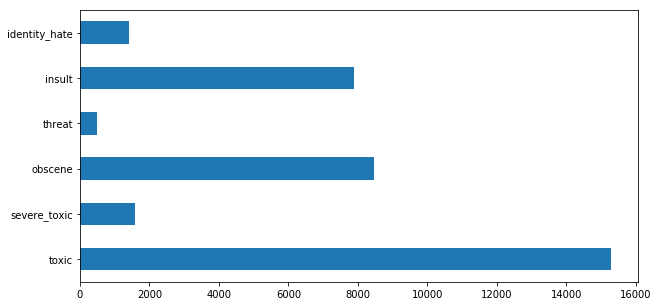

In [5]:
# plotting only the True values under each labels in training data
valCount.loc[1].plot.barh(figsize=(10,5))

In [6]:
# extracting "comment_text" column from training and testing for vectorizing
trainComTxt = training['comment_text']
testComTxt = testing['comment_text']
fullTxt = pd.concat([trainComTxt,testComTxt])

In [7]:
# creating pipeline for TF-IDF vectorizer and Multinomial naive bayes classifier for Grid search CV
txt_clf = Pipeline([('tfidfvec', TfidfVectorizer(analyzer='word',stop_words='english',use_idf=True,smooth_idf=True)),('nb', MultinomialNB())])

In [18]:
# setting up the possible parameters for TF-IDF and Multinomial naive bayes for Grid search CV
params = {'nb__fit_prior':(True,False),'nb__alpha':(0.25,0.5,0.75),'tfidfvec__sublinear_tf': (True, False),'tfidfvec__ngram_range': [(1,1),(1,2)],'tfidfvec__max_features': (20000,30000)}

In [19]:
# creating Grid search CV object with the above pipeline and params
gs_clf = GridSearchCV(txt_clf, params, n_jobs=2)

In [43]:
# validating the training data with 20000 records since Grid search CV takes huge amount of time to validate entire dataset
gstrain = training.iloc[:20000,1]
gstrain.head
gstar = training.iloc[:20000, 2:8]  
gstar.head

<bound method NDFrame.head of        toxic  severe_toxic  obscene  threat  insult  identity_hate
0          0             0        0       0       0              0
1          0             0        0       0       0              0
2          0             0        0       0       0              0
3          0             0        0       0       0              0
4          0             0        0       0       0              0
5          0             0        0       0       0              0
6          1             1        1       0       1              0
7          0             0        0       0       0              0
8          0             0        0       0       0              0
9          0             0        0       0       0              0
10         0             0        0       0       0              0
11         0             0        0       0       0              0
12         1             0        0       0       0              0
13         0             0      

In [44]:
# labels in list for iteration
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [45]:
# Grid search CV for all label and find best score and best param for respective labels
for label in labels:
    targ = gstar[label]
    strTm = datetime.now()
    gs_clf = gs_clf.fit(gstrain, targ)
    bestScore = gs_clf.best_score_
    bestParam = gs_clf.best_params_
    difTm = (datetime.now()-strTm)
    msg = "For %s, Best Params: %s and Best Score:%f, Time taken:%s sec." % (label,str(bestParam),bestScore,str(difTm.seconds))
    print(msg)

For toxic, Best Params: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tfidfvec__max_features': 20000, 'tfidfvec__ngram_range': (1, 2), 'tfidfvec__sublinear_tf': False} and Best Score:0.938600, Time taken:417 sec.
For severe_toxic, Best Params: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tfidfvec__max_features': 30000, 'tfidfvec__ngram_range': (1, 1), 'tfidfvec__sublinear_tf': True} and Best Score:0.988900, Time taken:423 sec.
For obscene, Best Params: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tfidfvec__max_features': 20000, 'tfidfvec__ngram_range': (1, 2), 'tfidfvec__sublinear_tf': False} and Best Score:0.963850, Time taken:424 sec.
For threat, Best Params: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tfidfvec__max_features': 20000, 'tfidfvec__ngram_range': (1, 1), 'tfidfvec__sublinear_tf': True} and Best Score:0.996650, Time taken:459 sec.
For insult, Best Params: {'nb__alpha': 0.25, 'nb__fit_prior': True, 'tfidfvec__max_features': 20000, 'tfidfvec__ngram_range': (1, 2), 'tfidfvec__sub

In [46]:
# TFidf vectorizer with suitable parameters identified from Grid search CV
tfidfvec = TfidfVectorizer(smooth_idf=True, sublinear_tf=True,analyzer='word', use_idf=True, ngram_range=(1, 1),stop_words="english", max_features=20000)

In [47]:
# Fit and Tranform comment texts into TF-IDF vectors for train and test data
tfidfvec.fit(fullTxt)
trainFeat = tfidfvec.transform(trainComTxt)
testFeat = tfidfvec.transform(testComTxt)

In [48]:
# dimensions of trainFeat
trainFeat.shape

(159571, 20000)

In [49]:
# dimensions of testFeat
testFeat.shape

(153164, 20000)

In [50]:
# Cross validation of with training data with roc_auc scoring with Multinomial NB parameters identified by Grid Search CV
for label in labels:
    trainTarg = training[label]
    cv = cross_val_score(MultinomialNB(alpha = 0.25),trainFeat,training[label], cv=10, scoring='roc_auc')
    score = cv.mean()
    msg = "%s: %f" % (label, score)
    print(msg)

toxic: 0.954089
severe_toxic: 0.971855
obscene: 0.962182
threat: 0.936511
insult: 0.961071
identity_hate: 0.952287


In [51]:
# dataframe for storing predicted probabilities
predResults = pd.DataFrame.from_dict({'Comment': testing['comment_text']})

In [52]:
# fitting the training data for all labels & predicting probabilities for test data using Naive Bayes classifier model
for label in labels:
    nb_classifier = MultinomialNB(fit_prior=True)
    nb_classifier.fit(trainFeat, trainTarg)
    predResults[label]=nb_classifier.predict_proba(testFeat)[:,1]

In [53]:
# validating size of predicted results
predResults.shape

(153164, 7)

In [56]:
# saving the predicted results as csv file
predResults.to_csv('text_naive_bayes.csv',index=False)